<b>Universidade Presbiteriana Mackenzie</b>

Computação Paralela - Turma 05P11

<b>Alan Meniuk Gleizer</b>, RA 10416804

16/05/2025

(sem dupla)

# Lab 0 - Verificação Ambiente Nvidia

O relatório deverá ser feito totalmente no notebook; nas primeiras células do notebook, coloque os resultados da execução dos seguintes comandos: nvidia-smi e nvaccelinfo.

<b> OBS. O laboratório foi desenvolvido e executado em ambiente local! Mantive em formato de Notebook para seguir as orientações, mas nada foi feito no Colab.</b>

In [9]:
!nvidia-smi

Fri May 16 12:24:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P8             21W /  285W |     611MiB /  16376MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
!nvaccelinfo


CUDA Driver Version:           12080
NVRM version:                  NVIDIA UNIX Open Kernel Module for x86_64  570.133.07  Release Build  (dvs-builder@U22-I3-G01-1-1)  Fri M
ar 14 12:57:14 UTC 2025

Device Number:                 0
Device Name:                   NVIDIA GeForce RTX 4070 Ti SUPER
Device Revision Number:        8.9
Global Memory Size:            16705781760
Number of Multiprocessors:     66
Concurrent Copy and Execution: Yes
Total Constant Memory:         65536
Total Shared Memory per Block: 49152
Registers per Block:           65536
Warp Size:                     32
Maximum Threads per Block:     1024
Maximum Block Dimensions:      1024, 1024, 64
Maximum Grid Dimensions:       2147483647 x 65535 x 65535
Maximum Memory Pitch:          2147483647B
Texture Alignment:             512B
Clock Rate:                    2670 MHz
Execution Timeout:             No
Integrated Device:             No
Can Map Host Memory:           Yes
Compute Mode:                  default
Concurrent

# Lab 1 - Programação - Integral Regra do Trapézio

Faça o código da integral pela regra do trapézio; pode utilizar a explicação mostrada nos slides de Introdução ao OpenMP (04 - Programacao de Memoria Compartilhada com OpenMP - ch5), na página 24.

In [1]:
%%writefile lab01_openACC.c

#include <stdio.h>
#include <stdlib.h>
#include <openacc.h>
#include <math.h>

/*
PARA COMPILAR
nvc -acc -Minfo=accel -fast lab01_openACC.c -o lab01_openACC -lm

PARA EXECUTAR
./lab01_openACC
*/

double f(double a)
{
    return sin(a);
}

double Local_trap(double a, double b, int n)
{
    double h = (b - a) / n;
    double approx = (f(a) + f(b)) / 2.0;
    int i;

    // aqui estamos paralelizando o for loop
    // uso de reduction NO LUGAR DE CRITICAL
    #pragma acc parallel loop reduction(+ : approx)
    for (i = 1; i <= n - 1; i++)
        approx += f(a + i * h);

    return h * approx;
}

int main(int argc, char *argv[])
{
    double global_result = 0.0; /* Store result in global_result */
    double a, b;                /* Left and right endpoints */
    int n;                      /* Total number of trapezoids */
    // int thread_count; // não sera usado em openACC

    // thread_count = strtol(argv[1], NULL, 10);
    printf("Enter a, b, and n\n");
    scanf("%lf %lf %d", &a, &b, &n);

    global_result += Local_trap(a, b, n);

    printf("With n = %d trapezoids, our estimate\n", n);
    printf("of the integral from %f to %f = %.14e\n", a, b, global_result);
    return 0;
} /* main */


Writing lab01_openACC.c


In [8]:
# PARA COMPILAR
!nvc -acc -Minfo=accel -fast lab01_openACC.c -o lab01_openACC -lm

# PARA EXECUTAR
a = 5
b = 15
n = 10
!echo "{a} {b} {n}" | ./lab01_openACC

f:
     16, Generating implicit acc routine seq
         Generating implicit acc routine seq
         Generating NVIDIA GPU code
Local_trap:
     29, Generating implicit firstprivate(h,n,a)
         Generating NVIDIA GPU code
         29, #pragma acc loop gang, vector(128) /* blockIdx.x threadIdx.x */
             Generating reduction(+:approx)
     29, Generating implicit copy(approx) [if not already present]
Enter a, b, and n
With n = 10 trapezoids, our estimate
of the integral from 5.000000 to 15.000000 = 9.54919772212994e-01


## Print de execução local como evidência:

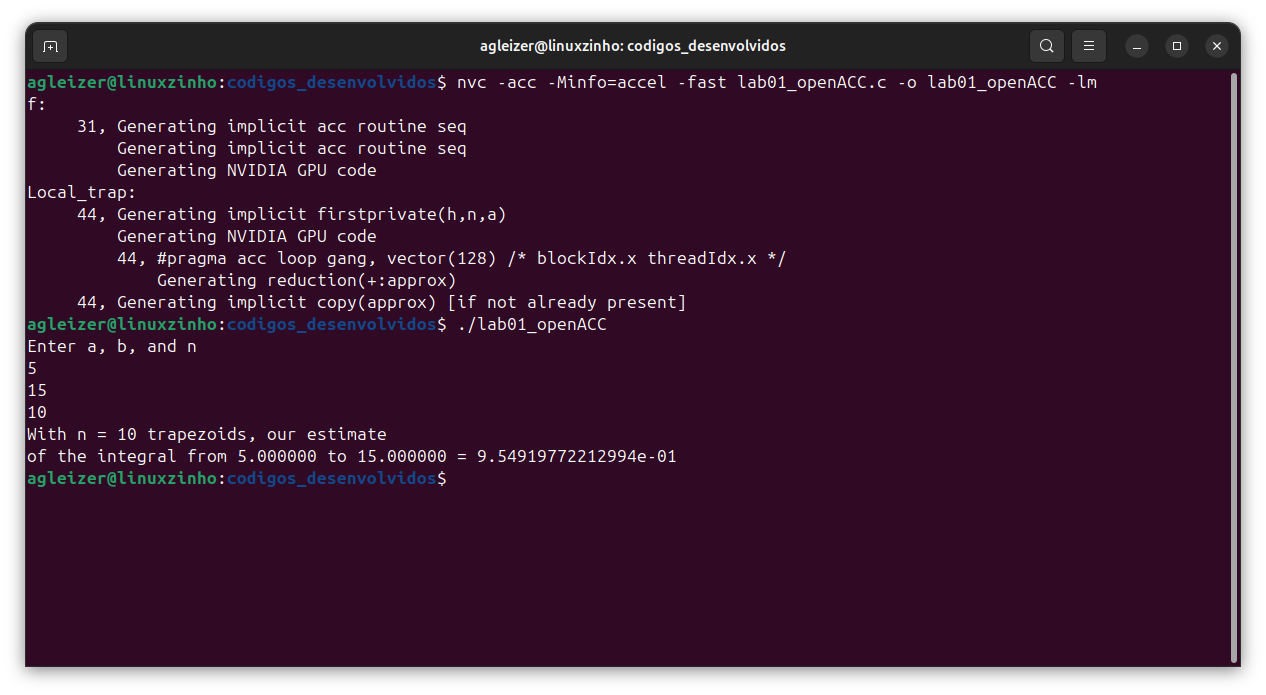

# Lab 3 - - Nova multiplicação de matrizes
Faça um programa de multiplicação de matrizes. Fique atento a um bom uso de cache (L1/L2)

[resto das orientações omitido no relatório.]

In [17]:
%%writefile lab03_openACC.c

/*
Universidade Presbiteriana Mackenzie
Computacao Paralela - Turma 05P11

Alan Meniuk Gleizer
RA 10416804
14/03/2025
*/

/*
Lab 3 - - Nova multiplicacao de matrizes
Faca um programa de multiplicacao de matrizes. Fique atento a um bom uso de cache (L1/L2).
>> REIMPLEMENTACAO EM OPENACC <<
*/

/*
PARA COMPILAR
nvc -acc -Minfo=accel -fast lab03_openACC.c -o lab03_openACC -lm

PARA EXECUTAR
./lab03_openACC
*/


#include <stdio.h>
#include <stdlib.h>
#include <openacc.h>
#include <time.h>

#define MAX_TAM 5000  // tamanho maximo
#define NUM_MAX 256 // num max para preenchimento da matriz

// preenche matrix com numero aleatorio entre 0 e numMax
void preencherMatriz(int matriz[MAX_TAM][MAX_TAM], int linhas, int colunas, int numMax) {
    for (int i = 0; i < linhas; i++)
        for (int j = 0; j < colunas; j++)
            matriz[i][j] = rand() % numMax;
}

// aplica convolucao! baseado na multiplicarMatrizPorBlocagem do lab3 original
// como os kernels tem todos os elementos == 1, sequer foi necessário criar uma matriz kernel
void aplicarConvolucao(int entrada[MAX_TAM][MAX_TAM], int saida[MAX_TAM][MAX_TAM], int tam_matriz, int tam_kernel) {
    int i, j, ki, kj;
    int limite = tam_matriz - tam_kernel + 1;

    #pragma acc parallel loop collapse(2) private(ki, kj)
    for (i = 0; i < limite; i++) {
        for (j = 0; j < limite; j++) {
            int soma = 0;
            for (ki = 0; ki < tam_kernel; ki++)
                for (kj = 0; kj < tam_kernel; kj++)
                    soma += entrada[i + ki][j + kj];
            saida[i][j] = soma;
        }
    }
}

int main() {
    int tam_matriz, tam_kernel;

    printf("Defina o tam. da matriz (1048 ou 4096): ");
    scanf("%d", &tam_matriz);

    printf("\nDefina o tam. do kernel (5, 11 ou 33): ");
    scanf("%d", &tam_kernel);

    if (tam_matriz > MAX_TAM || tam_kernel > tam_matriz) {
        printf("ERRO: tamanho invalido!\n");
        return 1;
    }

    // static necessario pois estava ocorrendo stack overflow
    static int entrada[MAX_TAM][MAX_TAM];
    static int saida[MAX_TAM][MAX_TAM];

    srand(time(NULL));
    preencherMatriz(entrada, tam_matriz, tam_matriz, NUM_MAX);

    clock_t inicio = clock();

    #pragma acc data copyin(entrada) copyout(saida)
    {
        aplicarConvolucao(entrada, saida, tam_matriz, tam_kernel);
    }

    clock_t fim = clock();
    double tempo = (double)(fim - inicio) * 1e6 / CLOCKS_PER_SEC;

    printf("\nMatriz tam. %d, kernel tam. %d:\n", tam_matriz, tam_kernel);
    printf("Convolucao concluida com sucesso.\n");
    printf("Tamanho da matriz de saida: %d x %d\n", tam_matriz - tam_kernel + 1, tam_matriz - tam_kernel + 1);
    //printf("Exemplo: saida[0][0] = %d\n", saida[0][0]);
    printf("Tempo de execucao: %.0f microsegundos\n\n", tempo);

    return 0;
}

Overwriting lab03_openACC.c


In [18]:
# PARA COMPILAR
!nvc -acc -Minfo=accel -fast lab03_openACC.c -o lab03_openACC -lm

aplicarConvolucao:
     48, Generating implicit firstprivate(tam_kernel,limite)
         Generating NVIDIA GPU code
         48, #pragma acc loop gang collapse(2) /* blockIdx.x */
         49,   /* blockIdx.x collapsed */
         51, #pragma acc loop seq
         52, #pragma acc loop vector(128) /* threadIdx.x */
             Generating implicit reduction(+:soma)
     48, Generating implicit copyin(entrada[:tam_matriz][:tam_matriz]) [if not already present]
         Generating implicit copyout(saida[:tam_matriz-tam_kernel+1][:tam_matriz-tam_kernel+1]) [if not already present]
     51, Loop is parallelizable
     52, Loop is parallelizable
main:
     83, Generating copyout(saida[:][:]) [if not already present]
         Generating copyin(entrada[:][:]) [if not already present]


In [19]:
# PARA EXECUTAR
# testes
a = 1048
b = 5
!echo "{a} {b}" | ./lab03_openACC

Defina o tam. da matriz (1048 ou 4096): 
Defina o tam. do kernel (5, 11 ou 33): 
Matriz tam. 1048, kernel tam. 5:
Convolucao concluida com sucesso.
Tamanho da matriz de saida: 1044 x 1044
Tempo de execucao: 240678 microsegundos



In [20]:
a = 1048
b = 11
!echo "{a} {b}" | ./lab03_openACC

Defina o tam. da matriz (1048 ou 4096): 
Defina o tam. do kernel (5, 11 ou 33): 
Matriz tam. 1048, kernel tam. 11:
Convolucao concluida com sucesso.
Tamanho da matriz de saida: 1038 x 1038
Tempo de execucao: 176238 microsegundos



In [21]:
a = 1048
b = 33
!echo "{a} {b}" | ./lab03_openACC

Defina o tam. da matriz (1048 ou 4096): 
Defina o tam. do kernel (5, 11 ou 33): 
Matriz tam. 1048, kernel tam. 33:
Convolucao concluida com sucesso.
Tamanho da matriz de saida: 1016 x 1016
Tempo de execucao: 216173 microsegundos



In [22]:
a = 4096
b = 5
!echo "{a} {b}" | ./lab03_openACC

Defina o tam. da matriz (1048 ou 4096): 
Defina o tam. do kernel (5, 11 ou 33): 
Matriz tam. 4096, kernel tam. 5:
Convolucao concluida com sucesso.
Tamanho da matriz de saida: 4092 x 4092
Tempo de execucao: 275342 microsegundos



In [23]:
a = 4096
b = 11
!echo "{a} {b}" | ./lab03_openACC

Defina o tam. da matriz (1048 ou 4096): 
Defina o tam. do kernel (5, 11 ou 33): 
Matriz tam. 4096, kernel tam. 11:
Convolucao concluida com sucesso.
Tamanho da matriz de saida: 4086 x 4086
Tempo de execucao: 409859 microsegundos



In [24]:
a = 4096
b = 33
!echo "{a} {b}" | ./lab03_openACC

Defina o tam. da matriz (1048 ou 4096): 
Defina o tam. do kernel (5, 11 ou 33): 
Matriz tam. 4096, kernel tam. 33:
Convolucao concluida com sucesso.
Tamanho da matriz de saida: 4064 x 4064
Tempo de execucao: 907932 microsegundos



## Print de execução local como evidência:

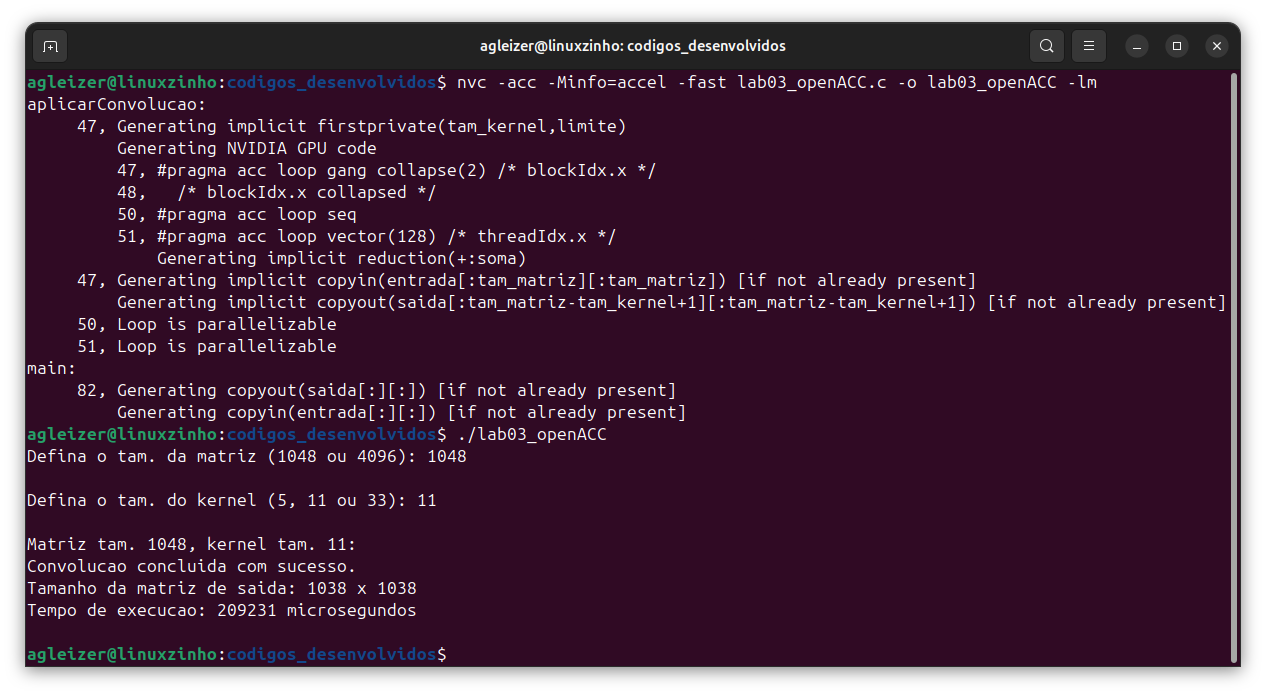